In [45]:
import time
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from statistics import mean
sns.set_theme()

In [23]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")

In [24]:
for col in stateless_df.columns:
    print(f"Percentage of missing values in {col} : {stateless_df[col].isna().sum()/stateless_df.shape[0]}")

Percentage of missing values in timestamp : 0.0
Percentage of missing values in FQDN_count : 0.0
Percentage of missing values in subdomain_length : 0.0
Percentage of missing values in upper : 0.0
Percentage of missing values in lower : 0.0
Percentage of missing values in numeric : 0.0
Percentage of missing values in entropy : 0.0
Percentage of missing values in special : 0.0
Percentage of missing values in labels : 0.0
Percentage of missing values in labels_max : 0.0
Percentage of missing values in labels_average : 0.0
Percentage of missing values in longest_word : 4.093971165236638e-05
Percentage of missing values in sld : 0.0
Percentage of missing values in len : 0.0
Percentage of missing values in subdomain : 0.0
Percentage of missing values in original_index : 0.0
Percentage of missing values in data_type : 0.0
Percentage of missing values in attack : 0.0
Percentage of missing values in origin : 0.0


In [25]:
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Train Accuracy: 0.75304406967684
Test Accuracy: 0.7526792258473485
Time elapsed: 38.73
Train Accuracy: 0.7570592090384288
Test Accuracy: 0.7367308936754665
Time elapsed: 38.93
Train Accuracy: 0.7505980002278096
Test Accuracy: 0.7625427556424241
Time elapsed: 39.78
Train Accuracy: 0.75024803184052
Test Accuracy: 0.763962441066547
Time elapsed: 41.45
Train Accuracy: 0.7541637158718918
Test Accuracy: 0.7482930758970431
Time elapsed: 34.95
Total time elapsed for predictions: 193.85


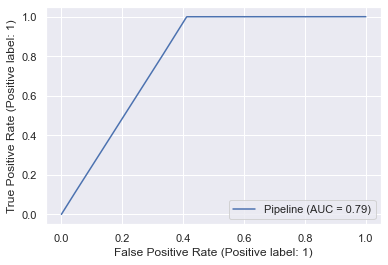

In [26]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]
y = stateless_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
    # ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
        ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])    
    pipe.fit(X_train, y_train)
    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateless += (end_fold - start_fold)
    
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

print(f"Total time elapsed for predictions: {(total_prediction_time_stateless):.2f}")
    
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
# importance = pipe["rf"].coef_[0]

# plt.bar([col for col in ["longest_word", "sld"]+[col for col in X if col not in ["longest_word", "sld"]]], importance)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()


In [27]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 193.853
Time to evaluate a single data point: 0.00025601


## Overall Results

In [28]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999460,0.595984,0.746704,462858.000000
1,0.611389,0.999494,0.758689,294353.000000
accuracy,0.752842,0.752842,0.752842,0.752842
macro avg,0.805425,0.797739,0.752696,757211.000000
weighted avg,0.848604,0.752842,0.751363,757211.000000


## Light-attack

In [29]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999672,0.608743,0.756700,60091.000000
1,0.644752,0.999719,0.783925,42683.000000
accuracy,0.771119,0.771119,0.771119,0.771119
macro avg,0.822212,0.804231,0.770312,102774.000000
weighted avg,0.852271,0.771119,0.768007,102774.000000


## Heavy-attack

In [30]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.998747,0.601253,0.750624,181694.000000
1,0.776377,0.999456,0.873905,251670.000000
accuracy,0.832503,0.832503,0.832503,0.832503
macro avg,0.887562,0.800354,0.812265,433364.000000
weighted avg,0.869609,0.832503,0.822218,433364.000000


In [31]:
stateless_df.Predictions.value_counts(normalize=True)

1    0.635498
0    0.364502
Name: Predictions, dtype: float64

# Stateful Model Reimplementation

In [32]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Train Accuracy: 0.7993790656416322
Test Accuracy: 0.8063180786326091
Time elapsed: 8.49
Train Accuracy: 0.8036330859769939
Test Accuracy: 0.7898742870223765
Time elapsed: 8.29
Train Accuracy: 0.7999799698594074
Test Accuracy: 0.8033994010034147
Time elapsed: 8.43
Train Accuracy: 0.8006047194826501
Test Accuracy: 0.8018923713778829
Time elapsed: 9.35
Train Accuracy: 0.8020497510539669
Test Accuracy: 0.7958833292001297
Time elapsed: 8.81
Total time elapsed for predictions: 43.36


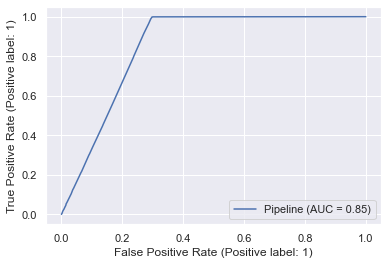

In [33]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns \
                 if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_rf = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
    # ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
    ])
    
    pipe.fit(X_train, y_train)
    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateful += (end_fold - start_fold)
    
    trained_pipes_rf.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)

print(f"Total time elapsed for predictions: {(total_prediction_time_stateful):.2f}")
    
    #display(pd.DataFrame(classification_report(y_test, pipe.predict(X_test), output_dict=True)).T)
rf_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()    
# get importance
# importance = pipe["rf"].coef_[0]

# plt.bar([col for col in X.columns], importance)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()

In [34]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 757211 rows is 43.363
Time to evaluate a single data point: 0.00005727


## Overall Results

In [35]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.992485,0.711403,0.828760,178782.000000
1,0.614829,0.988443,0.758104,83323.000000
accuracy,0.799473,0.799473,0.799473,0.799473
macro avg,0.803657,0.849923,0.793432,262105.000000
weighted avg,0.872429,0.799473,0.806298,262105.000000


## Light Attack Results

In [36]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.988495,0.713194,0.828575,22768.000000
1,0.629735,0.983267,0.767758,11295.000000
accuracy,0.802748,0.802748,0.802748,0.802748
macro avg,0.809115,0.848230,0.798166,34063.000000
weighted avg,0.869533,0.802748,0.808409,34063.000000


## Heavy Attack Results

In [37]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.984461,0.710487,0.825331,69016.000000
1,0.780994,0.989254,0.872874,72028.000000
accuracy,0.852847,0.852847,0.852847,0.852847
macro avg,0.882727,0.849871,0.849103,141044.000000
weighted avg,0.880555,0.852847,0.849610,141044.000000


In [38]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

## TWO STEP MODEL

In [39]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [40]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)
    

### LIGHT ATTACK

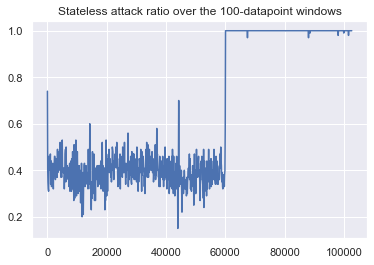

,precision,recall,f1-score,support
0,1.000000,0.948561,0.973602,60091.000000
1,0.932473,1.000000,0.965056,42683.000000
accuracy,0.969924,0.969924,0.969924,0.969924
macro avg,0.966236,0.974281,0.969329,102774.000000
weighted avg,0.971955,0.969924,0.970053,102774.000000


Total Estimated Time:  27.92694032414174


In [41]:
two_step(stateless_df, stateful_df, is_light=True)

### HEAVY ATTACK

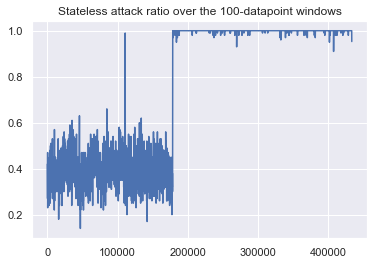

,precision,recall,f1-score,support
0,1.000000,0.939492,0.968802,181694.000000
1,0.958144,1.000000,0.978625,251670.000000
accuracy,0.974631,0.974631,0.974631,0.974631
macro avg,0.979072,0.969746,0.973713,433364.000000
weighted avg,0.975693,0.974631,0.974506,433364.000000


Total Estimated Time:  115.35244346571805


In [42]:
two_step(stateless_df, stateful_df, is_light=False)

# Saving the stateless and stateful models by training on all the data, in order to evaluate on the robustness queries:

## Stateless

In [68]:



X = stateless_df[[col for col in stateless_df.columns if col not in ["timestamp", "attack", "origin", "data_type", "original_index", "Predictions"]]]
y = stateless_df["attack"]

# Debug
#X = X[[col for col in X.columns if col not in ["longest_word", "sld"] ]]

category_pipeline = ColumnTransformer(
[
 #('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"), ["longest_word", "sld"]),
 ('scaler', StandardScaler(), [col for col in X if col not in ["longest_word", "sld"]])
 ]
)

pipe = Pipeline([
        ('rf', RandomForestClassifier(random_state=0))
 ]) 
pipe.fit(category_pipeline.fit_transform(X), y)
#pipe.fit(X, y)
joblib.dump(category_pipeline, "rf_baseline_column_transformer.pkl")
joblib.dump(pipe, 'rf_baseline_model.pkl')



['rf_baseline_model.pkl']

In [67]:
X.columns

Index(['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric',
       'entropy', 'special', 'labels', 'labels_max', 'labels_average', 'len',
       'subdomain'],
      dtype='object')

In [63]:
sum(y)/y.shape[0]

0.3887331272260968

In [64]:
stateless_df["attack"].value_counts(normalize=True)

0    0.611267
1    0.388733
Name: attack, dtype: float64

In [66]:
pipe.predict((X)).sum()/X.shape[0]

0.6354833725342077

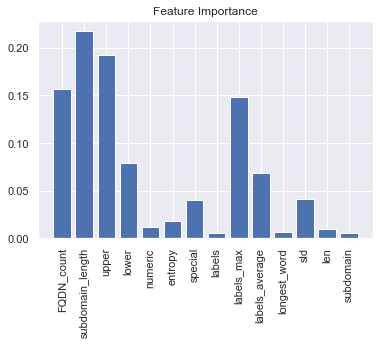

In [56]:
importance = pipe["rf"].feature_importances_

# plot feature importance
plt.title("Feature Importance")
plt.bar(X.columns, importance)
plt.xticks(rotation=90)
plt.show()    